In [8]:
# import everything here
import random
import spotipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials

# Adding Spotify API Credential

In [18]:
# API credential from your Spotify Developer Account
CLIENT_ID = ""
CLIENT_SECRET = ""

client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Getting the name list of the albums released by a chosen band/artist

In [10]:
# Function to get band ID by band name
def get_band_id(band_name):
    results = sp.search(q=band_name, type='artist')
    if len(results['artists']['items']) > 0:
        return results['artists']['items'][0]['id']
    else:
        return None

# Function to get albums by band ID
def get_band_albums(band_id):
    results = sp.artist_albums(band_id, album_type='album')
    albums = []
    for album in results['items']:
        album_name = album['name']
        album_year = album['release_date'][:4]
        albums.append((album_name, album_year))
    return albums

# User input for band name
band_name = input("Enter the name of a band: ")

# Get band ID
band_id = get_band_id(band_name)
if band_id:
    # Get albums by band ID
    albums = get_band_albums(band_id)
    if albums:
        # Create pandas DataFrame for albums
        df = pd.DataFrame(albums, columns=['Album', 'Year'])
        print("\nAlbums released by", band_name, ":\n")
        print(df.to_string(index=False))
    else:
        print("No albums found for", band_name)
else:
    print("Band not found.")


Albums released by Gates Of Ishtar :

                                           Album Year
At Dusk and Forever (Re-issue 2017) [Remastered] 1998
 The Dawn of Flames (Re-issue 2017) [Remastered] 1997
                                 A Bloodred Path 1996


# Getting the name list of the tracks in a chosen album

In [11]:
# Function to convert duration from milliseconds to minutes and seconds format
def convert_duration(duration_ms):
    minutes = duration_ms // 60000
    seconds = int((duration_ms % 60000) / 1000)
    return f"{minutes}:{seconds:02d}"

# Function to get the album ID by album name
def get_album_id(album_name):
    results = sp.search(q=album_name, type='album', limit=1)
    items = results['albums']['items']
    if items:
        return items[0]['id']
    else:
        return None

# Get the album name from the user
album_name = input("Enter the album name: ")

# Get the album ID
album_id = get_album_id(album_name)

if album_id:
    # Get the album tracks
    tracks = sp.album_tracks(album_id)['items']
    
    # Create a DataFrame to store the track information
    track_data = []
    for track in tracks:
        track_data.append({
            'Track Name': track['name'],
            'Track Number': track['track_number'],
            'Duration': convert_duration(track['duration_ms'])
        })
    
    # Display the tracks in a pandas DataFrame
    df = pd.DataFrame(track_data)
    print(df)
else:
    print("Album not found.")

                Track Name  Track Number Duration
0              Shadowminds             1     3:53
1         Days Of The Lost             2     3:37
2         The Needless End             3     4:04
3              Conditional             4     3:41
4          In Broken Trust             5     4:09
5                 Gateways             6     4:49
6  A Truth Worth Lying For             7     4:24
7      Feel What I Believe             8     3:59
8         Last Of Our Kind             9     4:04
9           The Most Alone            10     4:03


# Getting the mean Audio Features of a chosen album though Album ID (for accuracy)

Album Name: Whoracle

Mean Audio Features - Whoracle:
--------------------------------
danceability: 0.4636666666666666
energy: 0.9629166666666666
speechiness: 0.07943333333333333
acousticness: 0.00892556
instrumentalness: 0.7214916666666666
valence: 0.38166666666666665
time_signature: 3.75


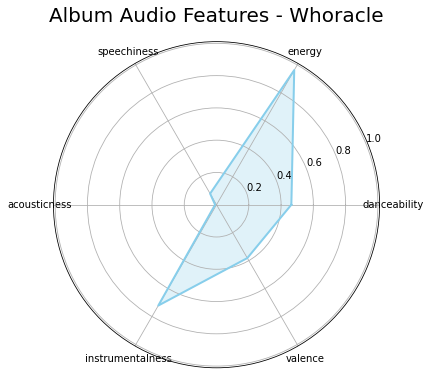

In [17]:
def get_album_audio_features(album_id):
    # Get album details
    album = sp.album(album_id)
    album_name = album['name']
    tracks = album['tracks']['items']
    track_ids = [track['id'] for track in tracks]

    # Initialize audio feature dictionary
    audio_features = {
        'danceability': [],
        'energy': [],
        'speechiness': [],
        'acousticness': [],
        'instrumentalness': [],
        'time_signature': [],
        'valence': []
    }

    # Get audio features for each track
    for i in range(0, len(track_ids), 50):
        audio_features_batch = sp.audio_features(track_ids[i:i + 50])
        for features in audio_features_batch:
            for key in audio_features.keys():
                audio_features[key].append(features[key])

    # Calculate mean audio feature values
    mean_audio_features = {key: np.mean(values) for key, values in audio_features.items()}
    return album_name, mean_audio_features


def plot_radar_chart(album_name, audio_features):
    categories = list(audio_features.keys())
    values = list(audio_features.values())

    # Remove 'time_signature' from the categories and values
    categories.remove('time_signature')
    values.remove(audio_features['time_signature'])

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='skyblue', alpha=0.25)
    ax.plot(angles, values, color='skyblue', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.yaxis.grid(True)
    ax.set_title(f'Album Audio Features - {album_name}', size=20, pad=20)

    plt.show()


# User input album ID
album_id = input("Enter the album ID: ")

# Get album name and mean audio features
album_name, audio_features = get_album_audio_features(album_id)

# Print album name
print(f"Album Name: {album_name}\n")

# Print mean audio feature values in a table
print(f"Mean Audio Features - {album_name}:")
print("--------------------------------")
for feature, value in audio_features.items():
    if feature == 'time_signature':
        continue
    print(f"{feature}: {value}")

# Print 'time_signature' separately at the end of the table
print(f"time_signature: {audio_features['time_signature']}")

# Plot radar chart
plot_radar_chart(album_name, audio_features)